
---

# Advanced Modeling Techniques with Amazon SageMaker

This Jupyter notebook guides you through implementing advanced modeling techniques using Amazon SageMaker, focusing on ensemble methods, model evaluation, and optimization techniques as covered in Chapter 5.

## Prerequisites

- An AWS account with SageMaker access
- Basic understanding of Python and machine learning concepts
- Familiarity with Jupyter notebooks


## Lab Overview

In this lab, you will:

1. Set up a SageMaker environment
2. Prepare data for modeling
3. Implement ensemble methods (bagging, boosting, and stacking)
4. Create a comprehensive model evaluation framework
5. Apply advanced optimization techniques
6. Clean up all resources

Let's get started!

## 1. Environment Setup

First, let's set up our SageMaker environment and install the necessary libraries:

In [1]:
# Install required packages
!pip3 install -q pandas numpy matplotlib seaborn scikit-learn xgboost


In [2]:

# Import necessary libraries
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           confusion_matrix, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb

# Set up the SageMaker session
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

print(f"SageMaker session established in region: {region}")
print(f"Using role: {role}")

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
SageMaker session established in region: us-east-1
Using role: arn:aws:iam::495304082646:role/service-role/AmazonSageMaker-ExecutionRole-20250308T154241


## 2. Data Preparation

We'll use the Breast Cancer Wisconsin dataset for this lab, which is a binary classification problem:

In [3]:
# Load the dataset
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

# Print dataset information
print(f"Dataset shape: {X.shape}")
print(f"Number of features: {len(cancer.feature_names)}")
print(f"Target distribution: {np.bincount(y)}")
print(f"Class names: {cancer.target_names}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Dataset shape: (569, 30)
Number of features: 30
Target distribution: [212 357]
Class names: ['malignant' 'benign']
Training set shape: (455, 30)
Testing set shape: (114, 30)


Let's visualize some of the data to understand it better:

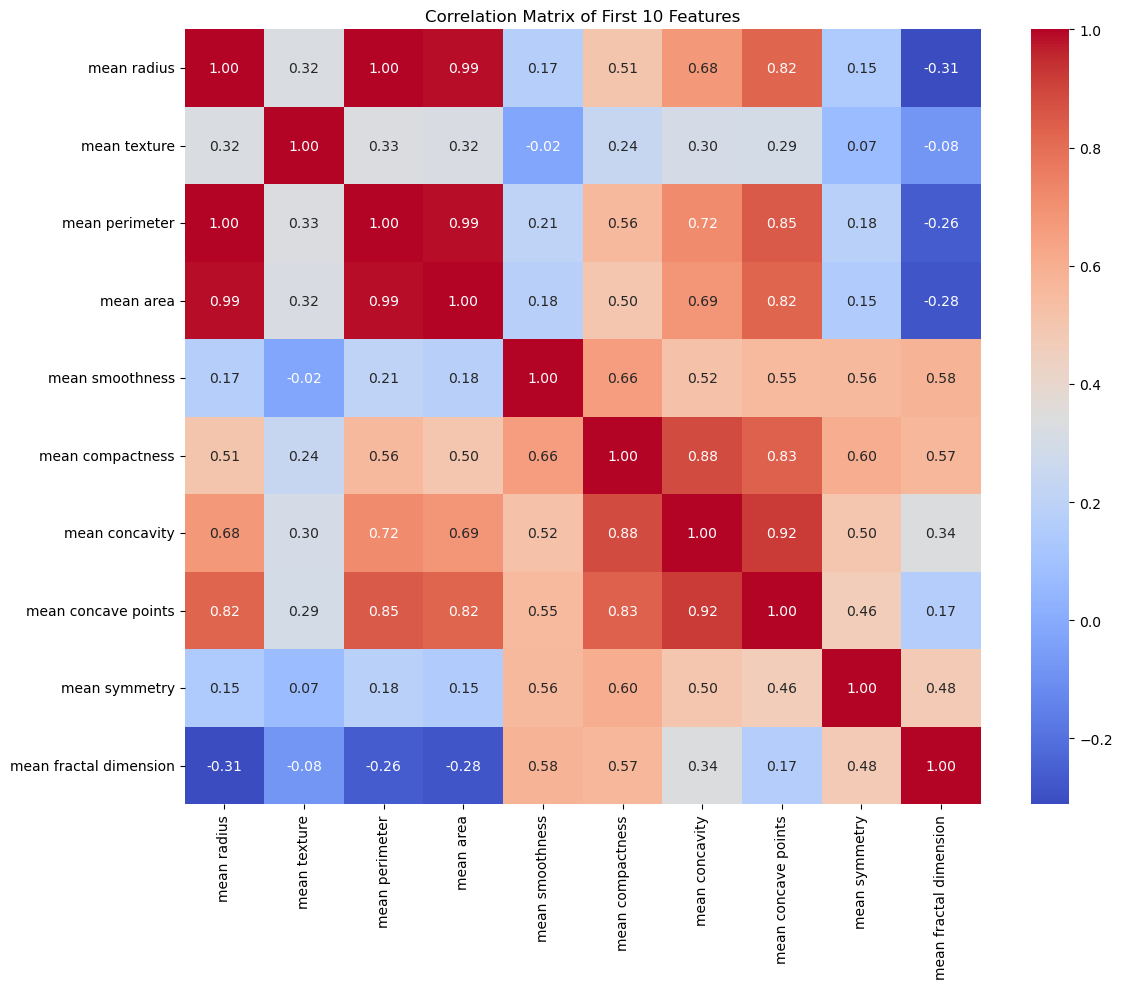

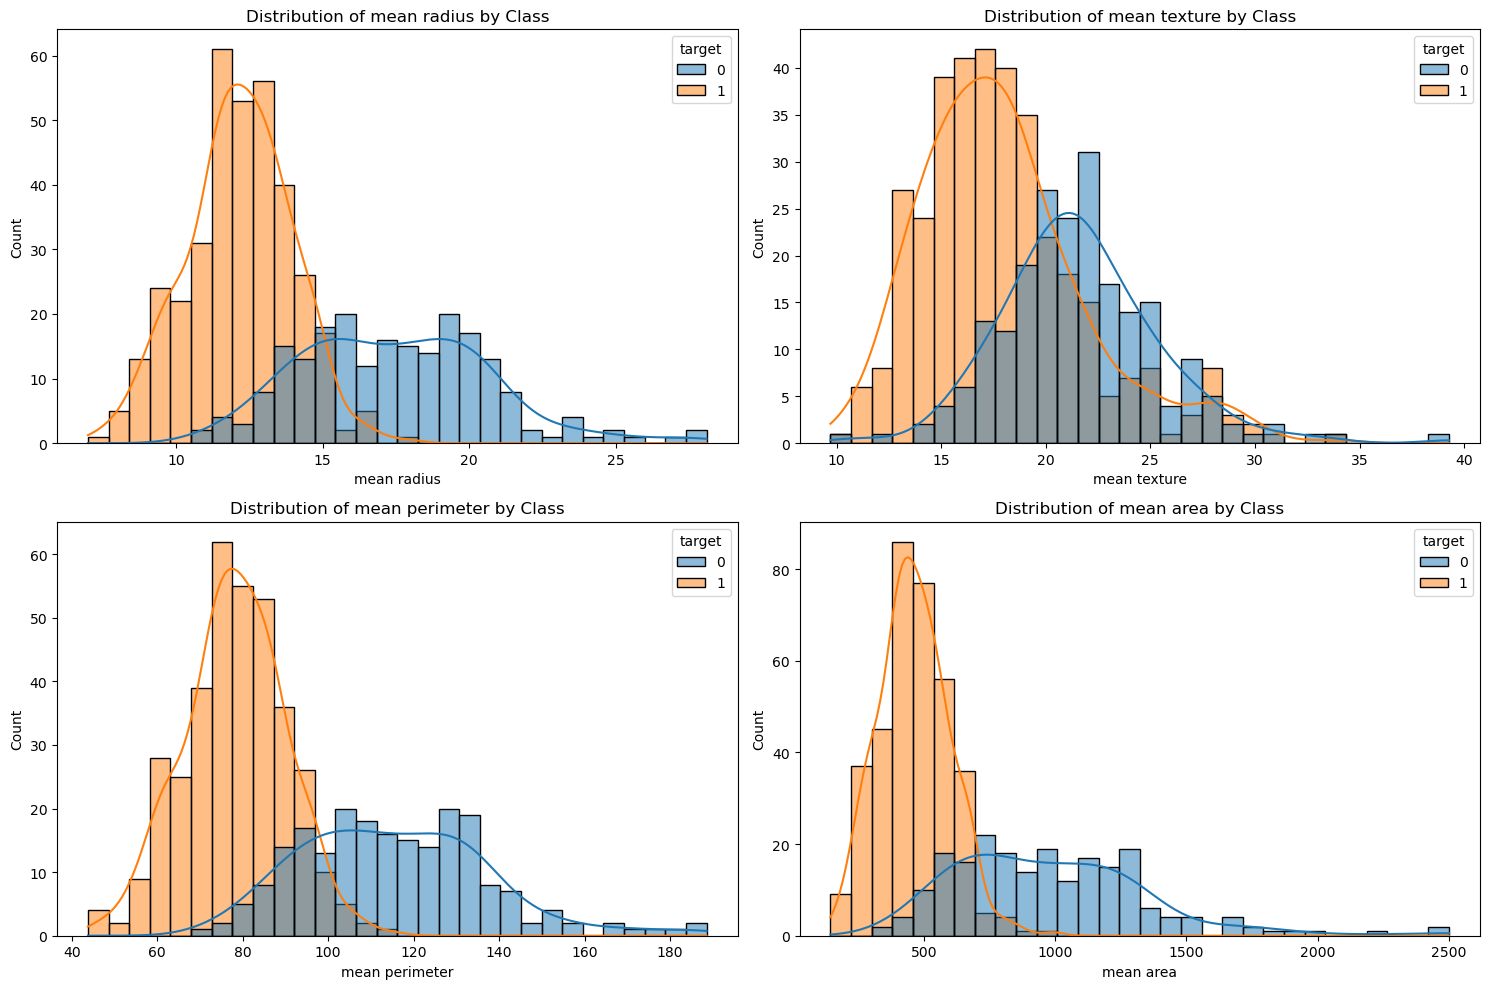

In [4]:
# Create a DataFrame for easier visualization
cancer_df = pd.DataFrame(X, columns=cancer.feature_names)
cancer_df['target'] = y

# Plot correlation matrix for the first 10 features
plt.figure(figsize=(12, 10))
correlation_matrix = cancer_df.iloc[:, :10].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of First 10 Features')
plt.tight_layout()
plt.show()

# Plot distribution of a few key features by class
plt.figure(figsize=(15, 10))
features_to_plot = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
for i, feature in enumerate(features_to_plot):
    plt.subplot(2, 2, i+1)
    sns.histplot(data=cancer_df, x=feature, hue='target', kde=True, bins=30)
    plt.title(f'Distribution of {feature} by Class')
plt.tight_layout()
plt.show()

## 3. Implementing Ensemble Methods

### 3.1 Bagging with Random Forest

Random Forest (Bagging) Performance:
Accuracy: 0.9561
Precision: 0.9583
Recall: 0.9718
F1 Score: 0.9650


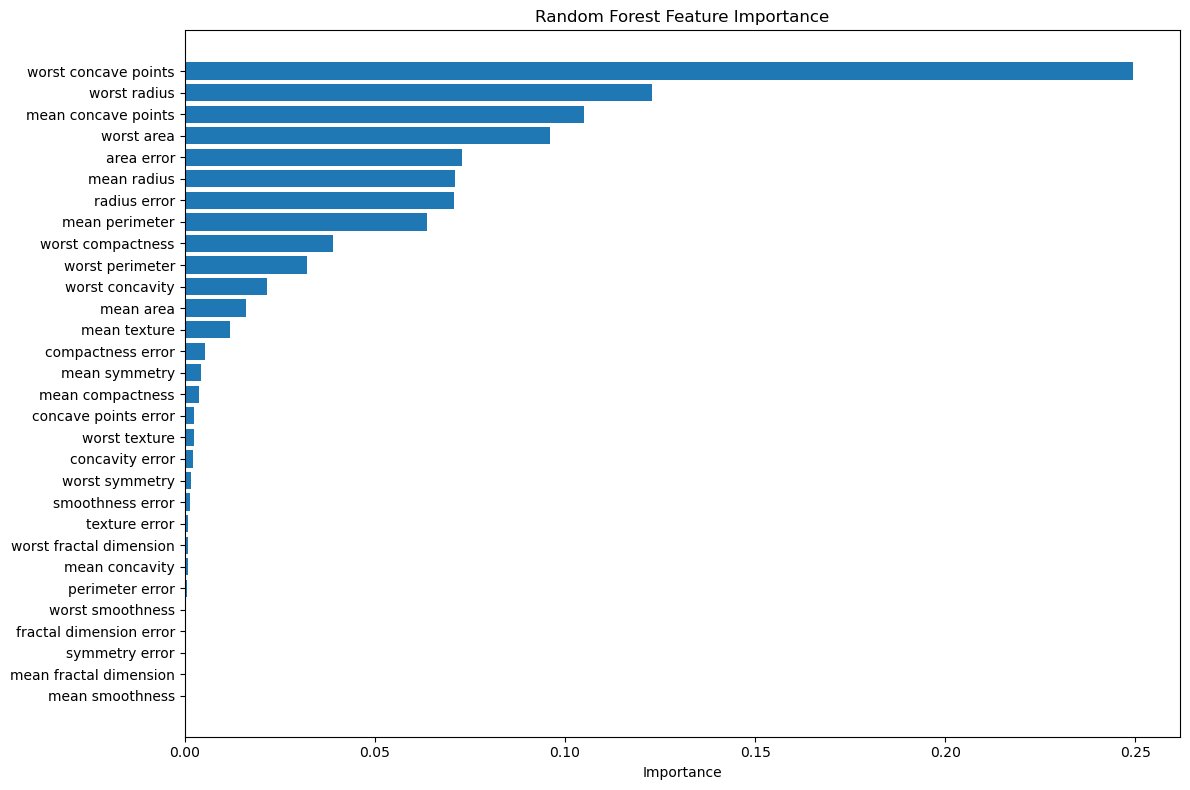

In [5]:
# Train a Random Forest classifier (bagging ensemble)
rf_model = RandomForestClassifier(n_estimators=10, max_depth=3, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test_scaled)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

print("Random Forest (Bagging) Performance:")
print(f"Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"Precision: {precision_score(y_test, rf_preds):.4f}")
print(f"Recall: {recall_score(y_test, rf_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_preds):.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [cancer.feature_names[i] for i in sorted_idx])
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

### 3.2 Boosting with XGBoost


XGBoost (Boosting) Performance:
Accuracy: 0.9737
Precision: 0.9722
Recall: 0.9859
F1 Score: 0.9790


<Figure size 1200x800 with 0 Axes>

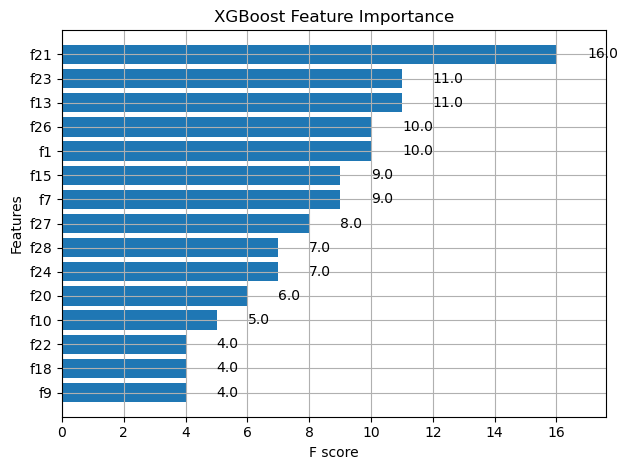

In [6]:
# Train an XGBoost model (boosting ensemble)
dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
dtest = xgb.DMatrix(X_test_scaled, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

xgb_model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100,
    evals=[(dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Make predictions
xgb_probs = xgb_model.predict(dtest)
xgb_preds = [1 if prob > 0.5 else 0 for prob in xgb_probs]

print("\nXGBoost (Boosting) Performance:")
print(f"Accuracy: {accuracy_score(y_test, xgb_preds):.4f}")
print(f"Precision: {precision_score(y_test, xgb_preds):.4f}")
print(f"Recall: {recall_score(y_test, xgb_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, xgb_preds):.4f}")

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

### 3.3 Stacking Ensemble

In [7]:
# Define base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=5, random_state=42)),
    ('svm', SVC(probability=True, random_state=42))
]

# Define meta-learner
meta_learner = LogisticRegression(random_state=42)

# Create and train stacking ensemble
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

stacking_model.fit(X_train_scaled, y_train)

# Make predictions
stacking_preds = stacking_model.predict(X_test_scaled)
stacking_probs = stacking_model.predict_proba(X_test_scaled)[:, 1]

print("\nStacking Ensemble Performance:")
print(f"Accuracy: {accuracy_score(y_test, stacking_preds):.4f}")
print(f"Precision: {precision_score(y_test, stacking_preds):.4f}")
print(f"Recall: {recall_score(y_test, stacking_preds):.4f}")
print(f"F1 Score: {f1_score(y_test, stacking_preds):.4f}")


Stacking Ensemble Performance:
Accuracy: 0.9737
Precision: 0.9722
Recall: 0.9859
F1 Score: 0.9790


## 4. Model Evaluation Framework

Let's create a comprehensive evaluation framework to compare our models:

Random Forest: Acc=0.9561, Prec=0.9583, Rec=0.9718, F1=0.9650


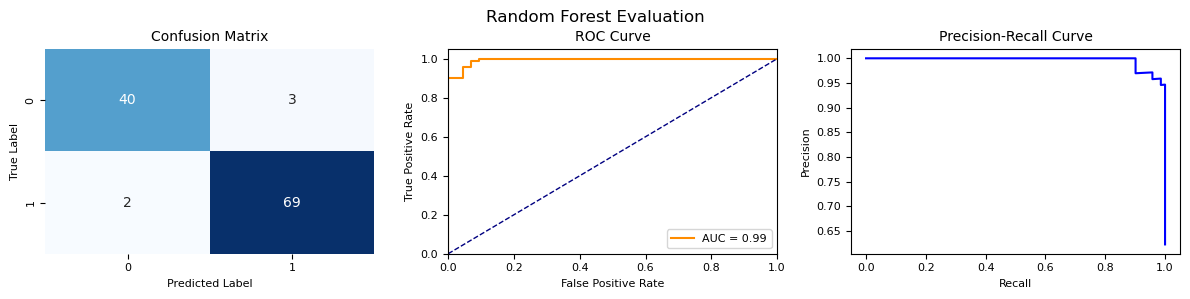

XGBoost: Acc=0.9737, Prec=0.9722, Rec=0.9859, F1=0.9790


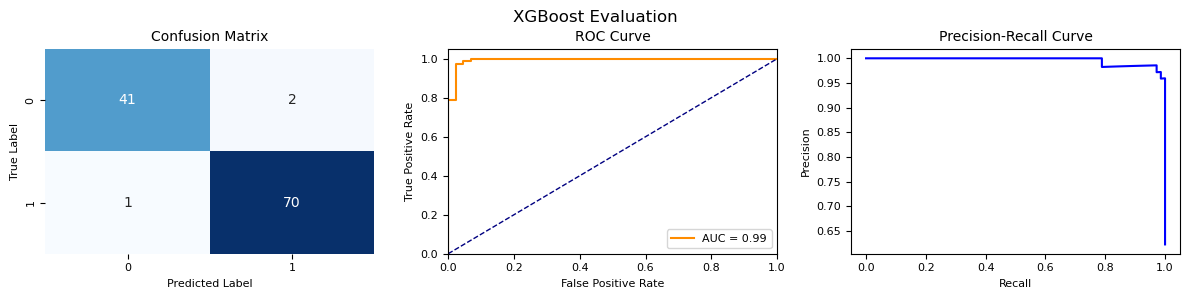

Stacking Ensemble: Acc=0.9737, Prec=0.9722, Rec=0.9859, F1=0.9790


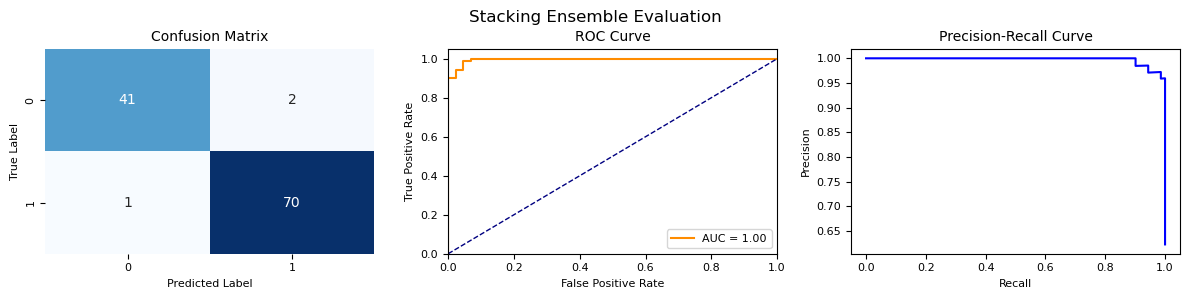

<Figure size 800x400 with 0 Axes>

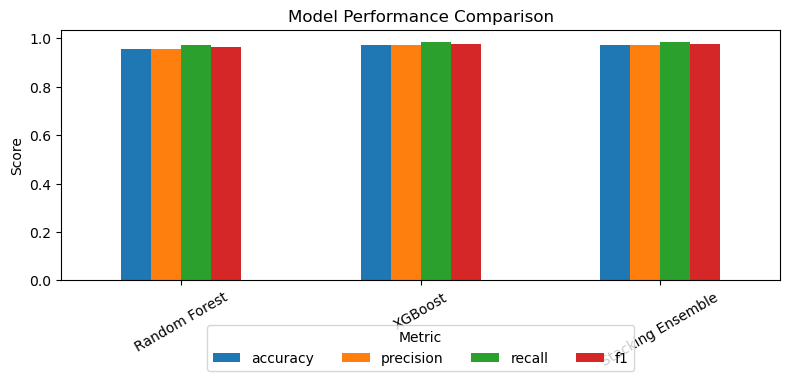

In [8]:
def evaluate_model(y_true, y_pred, y_prob, model_name, metrics_dict=None):
    """
    Compact model evaluation function for reports
    """
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    # Store metrics if dictionary provided
    if metrics_dict is not None:
        metrics_dict[model_name] = metrics
    
    # Print metrics in compact format
    print(f"{model_name}: Acc={metrics['accuracy']:.4f}, Prec={metrics['precision']:.4f}, "
          f"Rec={metrics['recall']:.4f}, F1={metrics['f1']:.4f}")
    
    # Create subplot figure for all visualizations
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
    ax[0].set_title(f'Confusion Matrix', fontsize=10)
    ax[0].set_ylabel('True Label', fontsize=8)
    ax[0].set_xlabel('Predicted Label', fontsize=8)
    ax[0].tick_params(labelsize=8)
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, color='darkorange', lw=1.5, label=f'AUC = {roc_auc:.2f}')
    ax[1].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('False Positive Rate', fontsize=8)
    ax[1].set_ylabel('True Positive Rate', fontsize=8)
    ax[1].set_title(f'ROC Curve', fontsize=10)
    ax[1].legend(loc="lower right", fontsize=8)
    ax[1].tick_params(labelsize=8)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    ax[2].plot(recall, precision, color='blue', lw=1.5)
    ax[2].set_xlabel('Recall', fontsize=8)
    ax[2].set_ylabel('Precision', fontsize=8)
    ax[2].set_title(f'Precision-Recall Curve', fontsize=10)
    ax[2].tick_params(labelsize=8)
    
    plt.suptitle(f'{model_name} Evaluation', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
    return metrics

# Dictionary to store metrics for comparison
all_metrics = {}

# Evaluate all models
rf_metrics = evaluate_model(y_test, rf_preds, rf_probs, "Random Forest", all_metrics)
xgb_metrics = evaluate_model(y_test, xgb_preds, xgb_probs, "XGBoost", all_metrics)
stacking_metrics = evaluate_model(y_test, stacking_preds, stacking_probs, "Stacking Ensemble", all_metrics)

# Create comparison DataFrame
comparison = pd.DataFrame(all_metrics).T

# Plot comparison as a single compact chart
plt.figure(figsize=(8, 4))
comparison.plot(kind='bar', figsize=(8, 4))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=30)
plt.legend(title='Metric', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.tight_layout()
plt.show()


## 5. Cross-Validation Techniques

Let's implement different cross-validation strategies to evaluate our models more thoroughly:

Random Forest with KFold (k=5): mean F1 = 0.9660, std = 0.0131
Random Forest with StratifiedKFold (k=5): mean F1 = 0.9652, std = 0.0178
XGBoost with KFold (k=5): mean F1 = 0.9665, std = 0.0083
XGBoost with StratifiedKFold (k=5): mean F1 = 0.9665, std = 0.0156


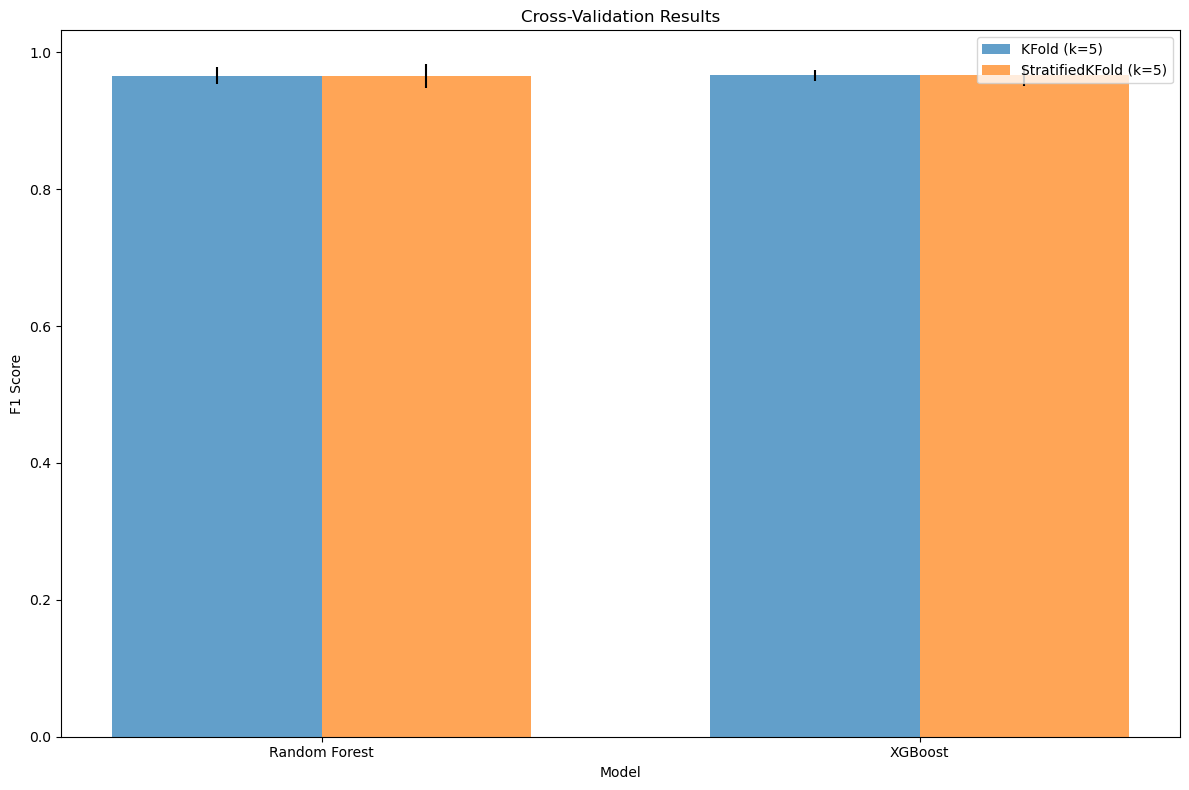

In [9]:
# Define cross-validation strategies
cv_strategies = {
    'KFold (k=5)': KFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold (k=5)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
}

# Define models to evaluate
models_for_cv = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6,
        eta=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
}

# Perform cross-validation
cv_results = {}
for model_name, model in models_for_cv.items():
    cv_results[model_name] = {}
    for cv_name, cv in cv_strategies.items():
        scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1')
        cv_results[model_name][cv_name] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
        print(f"{model_name} with {cv_name}: mean F1 = {scores.mean():.4f}, std = {scores.std():.4f}")

# Visualize cross-validation results
plt.figure(figsize=(12, 8))
bar_width = 0.35
index = np.arange(len(models_for_cv))

for i, cv_name in enumerate(cv_strategies.keys()):
    means = [cv_results[model_name][cv_name]['mean'] for model_name in models_for_cv.keys()]
    stds = [cv_results[model_name][cv_name]['std'] for model_name in models_for_cv.keys()]
    
    plt.bar(index + i*bar_width, means, bar_width, yerr=stds, 
            label=cv_name, alpha=0.7)

plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Cross-Validation Results')
plt.xticks(index + bar_width/2, models_for_cv.keys())
plt.legend()
plt.tight_layout()
plt.show()

## 6. Advanced Optimization

Let's implement hyperparameter tuning to optimize our models:

Tuning Random Forest...
Best parameters: {'max_depth': None, 'min_samples_split': 3, 'n_estimators': 100}
Optimized Random Forest: Acc=0.9649, Prec=0.9589, Rec=0.9859, F1=0.9722

Improvement after optimization:
Accuracy: 0.0088 (0.9%)
Precision: 0.0006 (0.1%)
Recall: 0.0141 (1.4%)
F1: 0.0072 (0.7%)


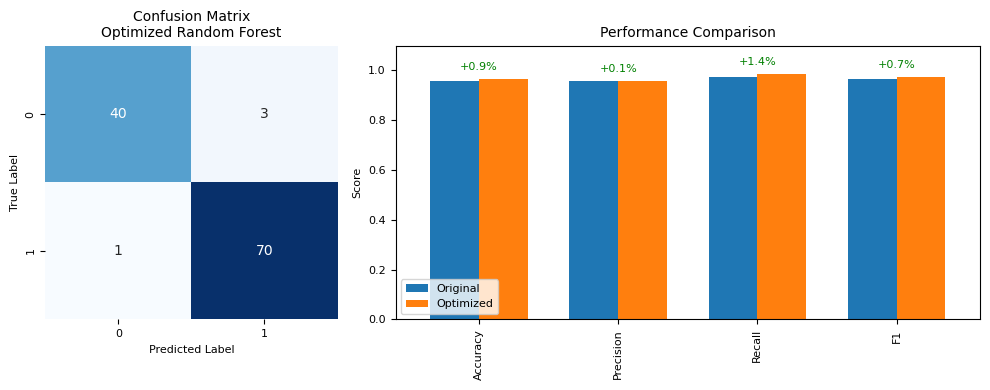

In [12]:
from sklearn.model_selection import GridSearchCV
def tune_and_evaluate_model(base_model, param_grid, X_train, y_train, X_test, y_test, model_name, original_metrics=None):
    """
    Compact function for model tuning and evaluation
    """
    # Create figure for results
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1, 2]})
    
    # Perform grid search
    print(f"Tuning {model_name}...")
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,
        scoring='f1',
        n_jobs=-1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")
    
    # Evaluate optimized model
    best_preds = best_model.predict(X_test)
    best_probs = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    best_metrics = {
        'accuracy': accuracy_score(y_test, best_preds),
        'precision': precision_score(y_test, best_preds),
        'recall': recall_score(y_test, best_preds),
        'f1': f1_score(y_test, best_preds)
    }
    
    # Print metrics in compact format
    print(f"Optimized {model_name}: Acc={best_metrics['accuracy']:.4f}, Prec={best_metrics['precision']:.4f}, "
          f"Rec={best_metrics['recall']:.4f}, F1={best_metrics['f1']:.4f}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, best_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False)
    ax[0].set_title(f'Confusion Matrix\nOptimized {model_name}', fontsize=10)
    ax[0].set_ylabel('True Label', fontsize=8)
    ax[0].set_xlabel('Predicted Label', fontsize=8)
    ax[0].tick_params(labelsize=8)
    
    # Compare with original model if provided
    if original_metrics:
        # Create comparison dataframe
        metrics_df = pd.DataFrame({
            'Original': [original_metrics['accuracy'], original_metrics['precision'], 
                         original_metrics['recall'], original_metrics['f1']],
            'Optimized': [best_metrics['accuracy'], best_metrics['precision'], 
                          best_metrics['recall'], best_metrics['f1']],
            'Improvement': [best_metrics['accuracy'] - original_metrics['accuracy'],
                           best_metrics['precision'] - original_metrics['precision'],
                           best_metrics['recall'] - original_metrics['recall'],
                           best_metrics['f1'] - original_metrics['f1']]
        }, index=['Accuracy', 'Precision', 'Recall', 'F1'])
        
        # Print comparison
        print("\nImprovement after optimization:")
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            improvement = best_metrics[metric] - original_metrics[metric]
            print(f"{metric.capitalize()}: {improvement:.4f} ({improvement/original_metrics[metric]*100:.1f}%)")
        
        # Plot comparison
        metrics_df[['Original', 'Optimized']].plot(kind='bar', ax=ax[1], width=0.7)
        
        # Add text annotations for improvement percentages
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            improvement = best_metrics[metric] - original_metrics[metric]
            percentage = improvement/original_metrics[metric]*100
            ax[1].annotate(f"+{percentage:.1f}%", 
                          xy=(i, best_metrics[metric]), 
                          xytext=(0, 5),
                          textcoords="offset points", 
                          ha='center', va='bottom',
                          fontsize=8, color='green')
        
        ax[1].set_title(f'Performance Comparison', fontsize=10)
        ax[1].set_ylabel('Score', fontsize=8)
        ax[1].set_ylim(0, 1.1)
        ax[1].legend(fontsize=8)
        ax[1].tick_params(labelsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return best_model, best_metrics

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [3, 5, 10, 50, 100],
    'max_depth': [None, 2, 3, 5, 10, 20],
    'min_samples_split': [2, 3, 5, 10]
}

# Tune and evaluate Random Forest
best_rf, best_rf_metrics = tune_and_evaluate_model(
    RandomForestClassifier(random_state=42),
    param_grid,
    X_train_scaled, 
    y_train,
    X_test_scaled,
    y_test,
    "Random Forest",
    rf_metrics
)


## 7. Clean Up Resources

Always clean up resources to avoid unnecessary charges:

In [13]:
import boto3
from botocore.exceptions import ClientError

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Function to delete all SageMaker models
def delete_all_models():
    try:
        # List all models
        models = sagemaker_client.list_models()
        for model in models['Models']:
            model_name = model['ModelName']
            print(f"Deleting model: {model_name}")
            sagemaker_client.delete_model(ModelName=model_name)
            print(f"Model {model_name} deleted.")
    except ClientError as e:
        print(f"Error while deleting models: {e}")

# Function to delete all SageMaker endpoints
def delete_all_endpoints():
    try:
        # List all endpoints
        endpoints = sagemaker_client.list_endpoints()
        for endpoint in endpoints['Endpoints']:
            endpoint_name = endpoint['EndpointName']
            print(f"Deleting endpoint: {endpoint_name}")
            sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
            print(f"Endpoint {endpoint_name} deleted.")
    except ClientError as e:
        print(f"Error while deleting endpoints: {e}")

# Function to delete all SageMaker endpoint configurations
def delete_all_endpoint_configs():
    try:
        # List all endpoint configurations
        endpoint_configs = sagemaker_client.list_endpoint_configs()
        for config in endpoint_configs['EndpointConfigs']:
            config_name = config['EndpointConfigName']
            print(f"Deleting endpoint configuration: {config_name}")
            sagemaker_client.delete_endpoint_config(EndpointConfigName=config_name)
            print(f"Endpoint configuration {config_name} deleted.")
    except ClientError as e:
        print(f"Error while deleting endpoint configurations: {e}")

# Clean up all SageMaker resources
def clean_up_sagemaker_resources():
    delete_all_models()
    delete_all_endpoints()
    delete_all_endpoint_configs()

# Call the clean-up function
clean_up_sagemaker_resources()


## Common Mistakes and Best Practices

### Common Mistakes

- Not scaling features before training models that are sensitive to feature scales
- Using the test set for hyperparameter tuning, leading to data leakage
- Forgetting to clean up AWS resources after completing the lab
- Misinterpreting evaluation metrics (e.g., high accuracy with imbalanced data)
- Ignoring cross-validation in favor of a single train-test split


### Best Practices

- Always scale features when using distance-based algorithms or neural networks
- Use cross-validation for more reliable model evaluation
- Examine multiple evaluation metrics, not just accuracy
- Visualize model performance using confusion matrices, ROC curves, and PR curves
- Implement proper resource cleanup to avoid unnecessary AWS charges
- Start with simpler models before moving to more complex ones
- Understand the bias-variance tradeoff when optimizing models
- Document your modeling process and decisions


## Conclusion

In this lab, you've learned how to:

- Implement and compare different ensemble methods (bagging, boosting, and stacking)
- Create a comprehensive model evaluation framework
- Apply cross-validation techniques to validate model performance
- Optimize models through hyperparameter tuning
- Visualize and interpret model results

